
# ENSO Recharge Oscillator Practical: Simulations and Forecasting
This notebook is the Recharge Oscillator (RO) Practical for the [ENSO Winter School 2025](https://sites.google.com/hawaii.edu/enso-winter-school-2025/). The practical covers theoretical and computational aspects of the RO model, its applications in ENSO simulations, and forecasting.

**Instructors**:
- Sen Zhao <zhaos@hawaii.edu>
- Soong-Ki Kim <sskk503@yonsei.ac.kr>        

**Reviewer**
- Jérôme Vialard

In this notebook, we will demonstrate how to `CRO` library for **Recharge-Oscilattor (RO)** model simulations

## RO equations
$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 - c_{T} T^3 + d_{T} T H + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T - b_h T^2 + \sigma_h \xi_h
$$

See the details in [Technical Note for the Community Recharge Oscillator (CRO) Model Package](./CRO_Code_Technical_Note_Winter_School_v1.0.pdf).


## Python libraries

Include libraries for both computing and visualization

In [9]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
    
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoMinorLocator
import datetime
from dateutil.relativedelta import *

import numpy as np
import xarray as xr
import seaborn as sns

from CRO import RO_solver
from CRO import RO_fitting

from XRO import XRO, xcorr
from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 Observed ENSO properties 

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).

Following Zhao et al. (2024), the standard XRO include the state vectors of ENSO and other climate modes in global oceans.
which includes 

$X_{ENSO}=[T_{ENSO}, WWV]$ 


### 2.1 ENSO time series

<xarray.Dataset>
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 ...
Data variables:
    Nino34   (time) float32 ...
    WWV      (time) float32 ...


Text(0.5, 1.0, 'ORAS5 Nino3.4 and WWV indices')

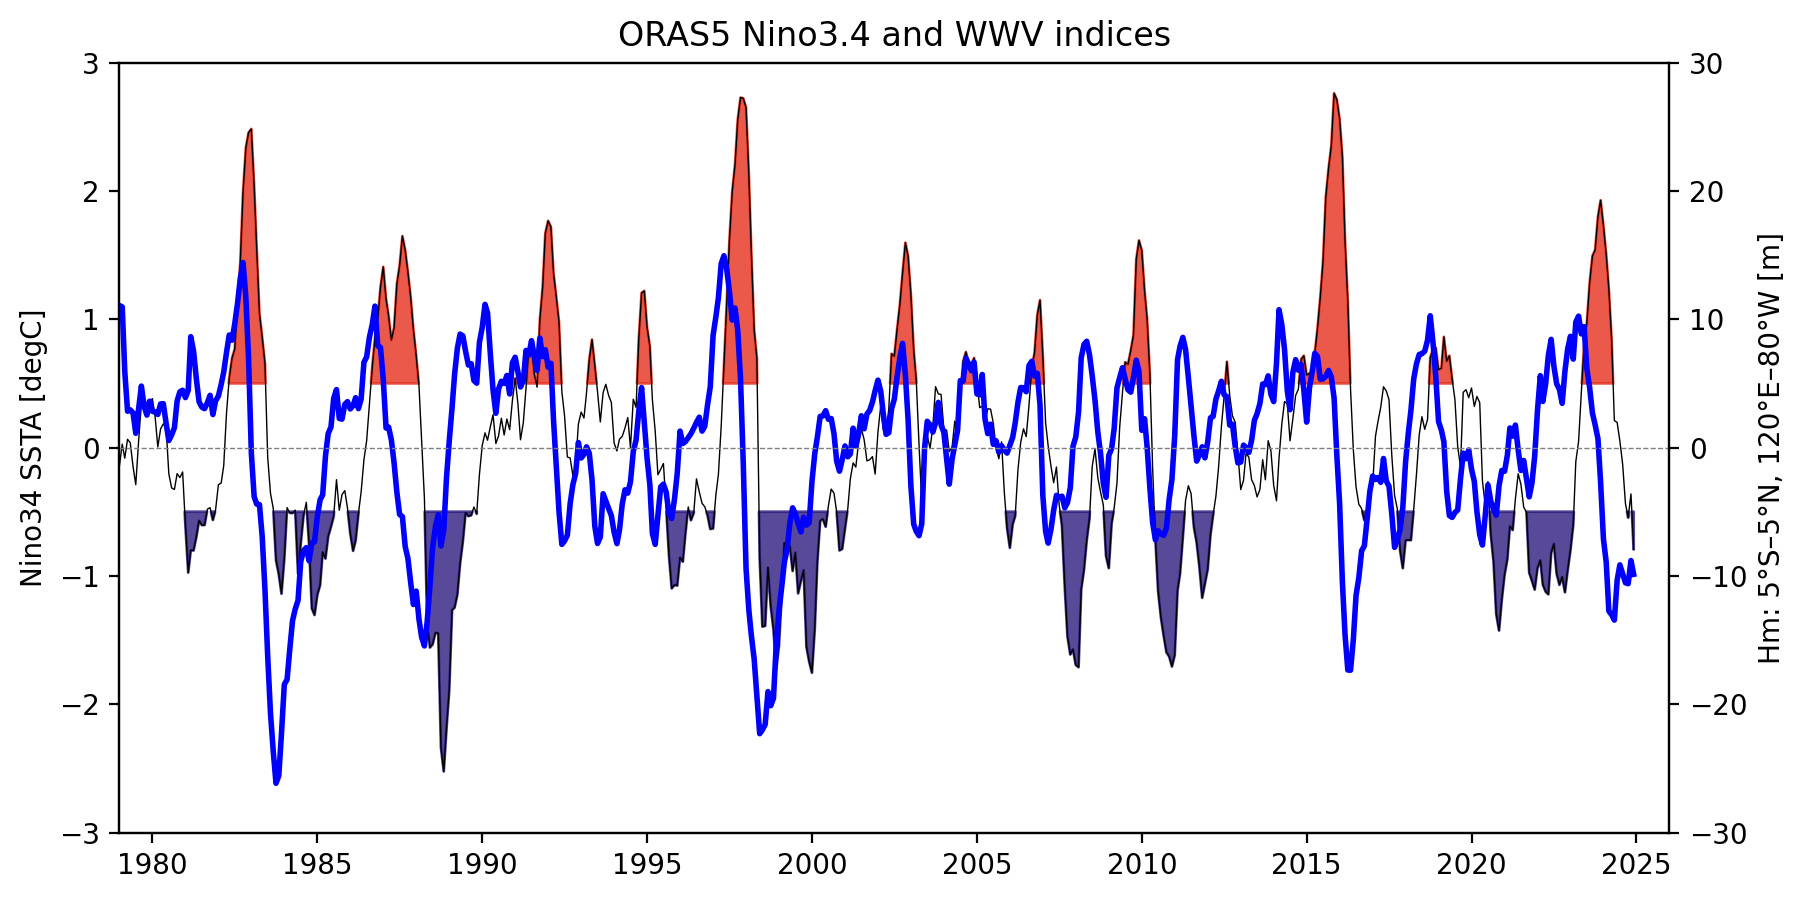

In [10]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
obs_ds = xr.open_dataset('../data/XRO_indices_oras5.nc').sel(time=slice('1979-01', '2024-12'))
obs_RO_ds = obs_ds[['Nino34', 'WWV']]
obs_XRO_ds = obs_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
print(obs_RO_ds)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plot_above_below_shading(obs_RO_ds['Nino34'], xtime=obs_RO_ds.time, c='black', lw=0.5, ax=ax)
# obs_RO_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_ylim([-3, 3])
ax.set_ylabel('Nino34 SSTA [degC]')

axR = ax.twinx()
obs_RO_ds['WWV'].plot(ax=axR, c='blue', lw=2)
axR.set_ylim([-30, 30])
axR.axhline(0, ls='--', c='gray', lw=0.5)

ax.set_xlim([datetime.datetime(1979, 1, 1), datetime.datetime(2026, 1, 1)])
ax.set_title('ORAS5 Nino3.4 and WWV indices')

### 2.2 Observed ENSO seasonal synchronization

It can be represented as ENSO SSTA's seasonal variance (or standard deviation)

In [11]:
stddevAC_obs_ds = obs_RO_ds.groupby('time.month').std('time')
print(stddevAC_obs_ds)

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Nino34   (month) float64 1.142 0.9521 0.7425 0.5979 ... 1.039 1.195 1.224
    WWV      (month) float64 5.734 6.448 7.07 7.344 ... 7.267 7.673 7.049 6.229


Text(0.5, 1.0, 'ENSO seasonal synchronization')

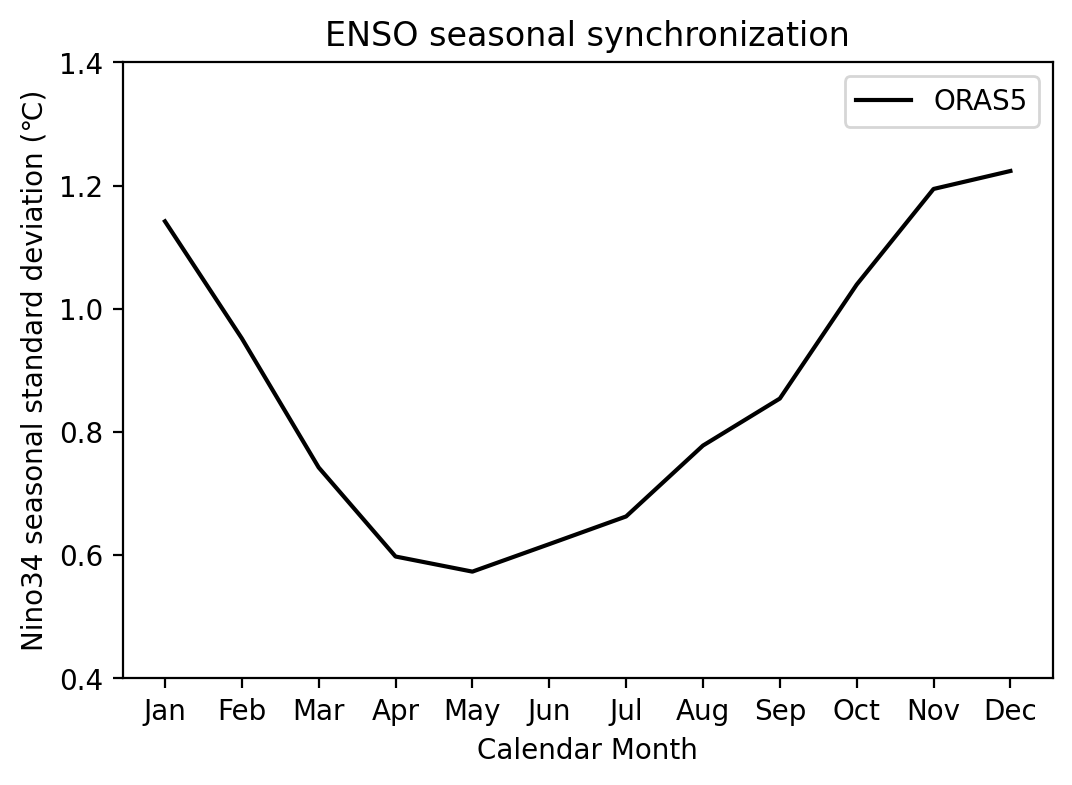

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plt.xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.legend()
plt.ylim([0.4, 1.4])
plt.title('ENSO seasonal synchronization')

### 2.3 Observed ENSO asymmetry and skewness

- check the function compute_skew in XRO_utils.py
- ENSO's skewness

In [14]:
skew_obs_ds = obs_RO_ds.skew('time')
print(skew_obs_ds)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    Nino34   float64 0.4996
    WWV      float64 -0.9064


### 2.4 ENSO SST-WWV relationships

## RO models in different complexities

### Linear RO (LRO)

### Seasonal RO (SRO)

### Nonlinear RO (NRO)

Here we include two versions of XRO model:
    - XRO model with annual mean, annual cycle, and semi-annual cycles components (XROac2)
    - XRO model with annual mean component only (XROac0)
Notes:
1. The monthly time series is used to train the XRO model, so we set `ncycle=12`. Therefore, the XRO simulate/reforecast output is also monthly mean time series.
2. It should be noted that the XRO accept higher resolution data such as (ncycle=52 for weekly data and ncycle=365 for daily data), similarly the output of simulate/reforecast will be weakly or daily automatically.

### Linear RO (LRO)


<xarray.Dataset>
Dimensions:  (time: 1200, member: 500)
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 0100-12-01 00:00:00
  * member   (member) int32 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    Nino34   (time, member) float64 0.003149 -0.1158 0.1518 ... 0.3081 0.1326
    WWV      (time, member) float64 10.36 11.75 9.055 ... 3.178 6.214 -10.58


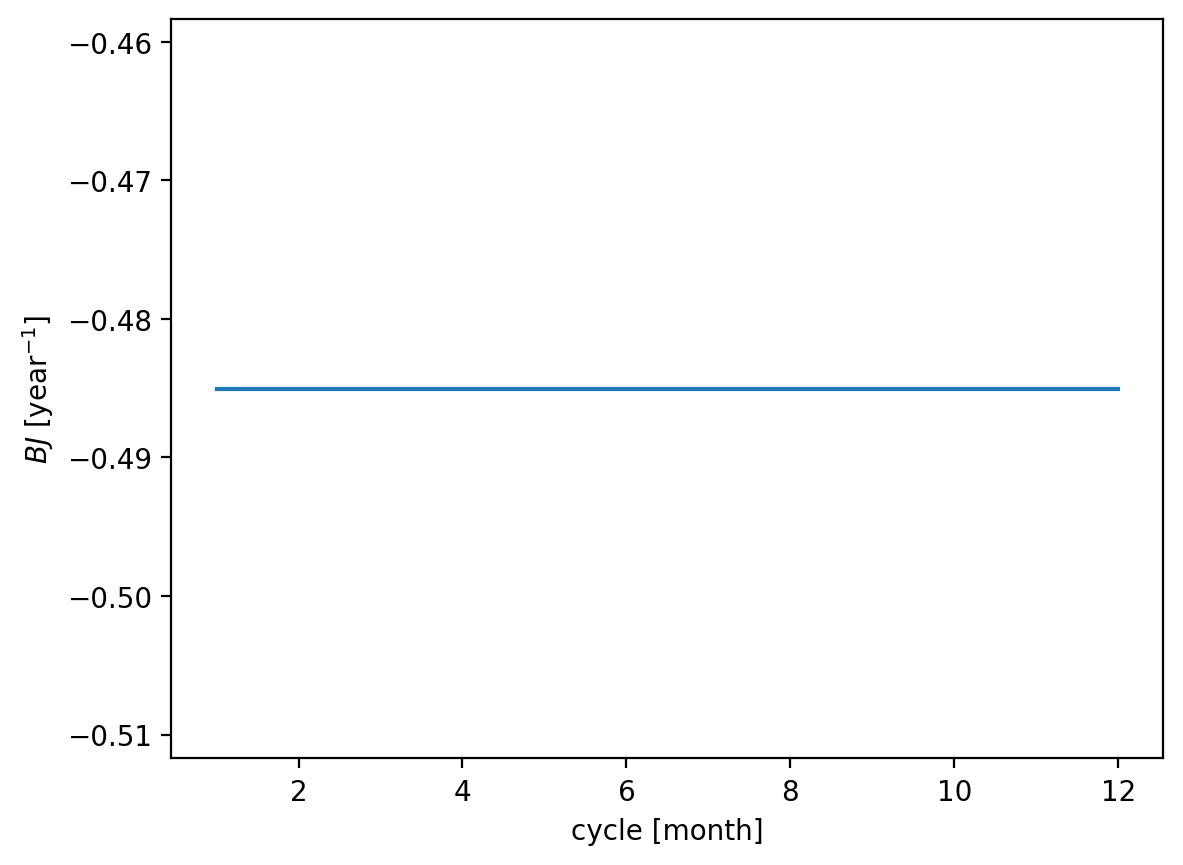

In [73]:
# RO model without annual cycles
fun_ac0 = XRO(ncycle=12, ac_order=0)
fit_LRO = fun_ac0.fit_matrix(train_ds, maskNT=[], maskNH=[])
fit_LRO_ds = fun_ac0.get_RO_parameters(fit_LRO)
fit_LRO_ds['BJ_ac'].plot()

seed = 1000
sim_LRO = fun_ac0.simulate(fit_ds=fit_LRO, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=500, noise_type='white', seed=seed, is_xi_stdac=False, xi_B=0)  
print(sim_LRO)

<xarray.Dataset>
Dimensions:  (time: 1200, member: 500)
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 0100-12-01 00:00:00
  * member   (member) int32 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    Nino34   (time, member) float64 -0.1039 -0.213 0.03028 ... 0.06326 0.3502
    WWV      (time, member) float64 10.38 11.65 9.167 ... 2.63 7.379 -7.261


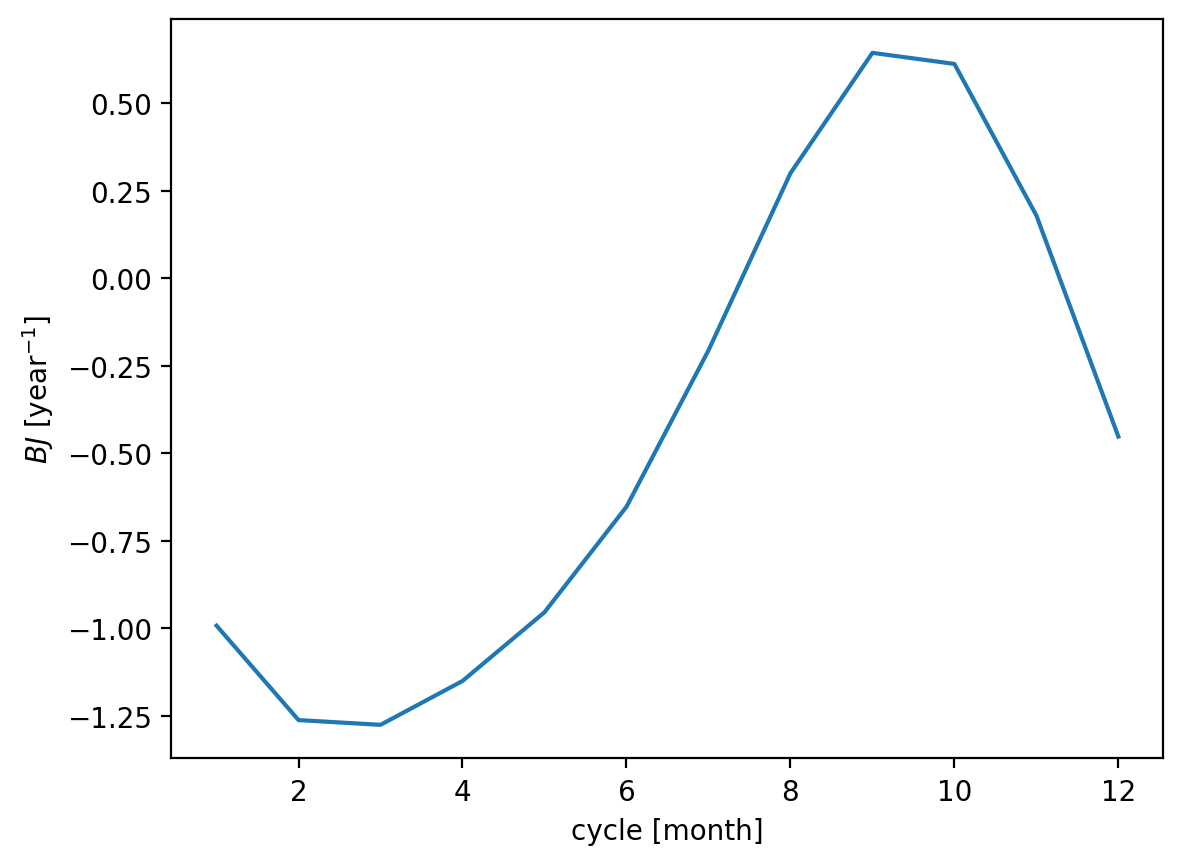

In [74]:
# model with annual mean, annual cycle, and semi-annual cycle
fun_ac2 = XRO(ncycle=12, ac_order=2)
fit_SRO = fun_ac2.fit_matrix(train_ds, maskNT=[], maskNH=[])
fit_SRO_ds = fun_ac0.get_RO_parameters(fit_SRO)
fit_SRO_ds['BJ_ac'].plot()

seed = 1000
sim_SRO = fun_ac0.simulate(fit_ds=fit_SRO, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=500, noise_type='white', seed=seed, is_xi_stdac=False, xi_B=0)  
print(sim_SRO)

<xarray.Dataset>
Dimensions:  (time: 1200, member: 500)
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 0100-12-01 00:00:00
  * member   (member) int32 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    Nino34   (time, member) float64 -0.09788 -0.2045 0.03353 ... -0.1 0.2962
    WWV      (time, member) float64 10.35 11.62 9.157 ... 2.441 6.861 -7.481


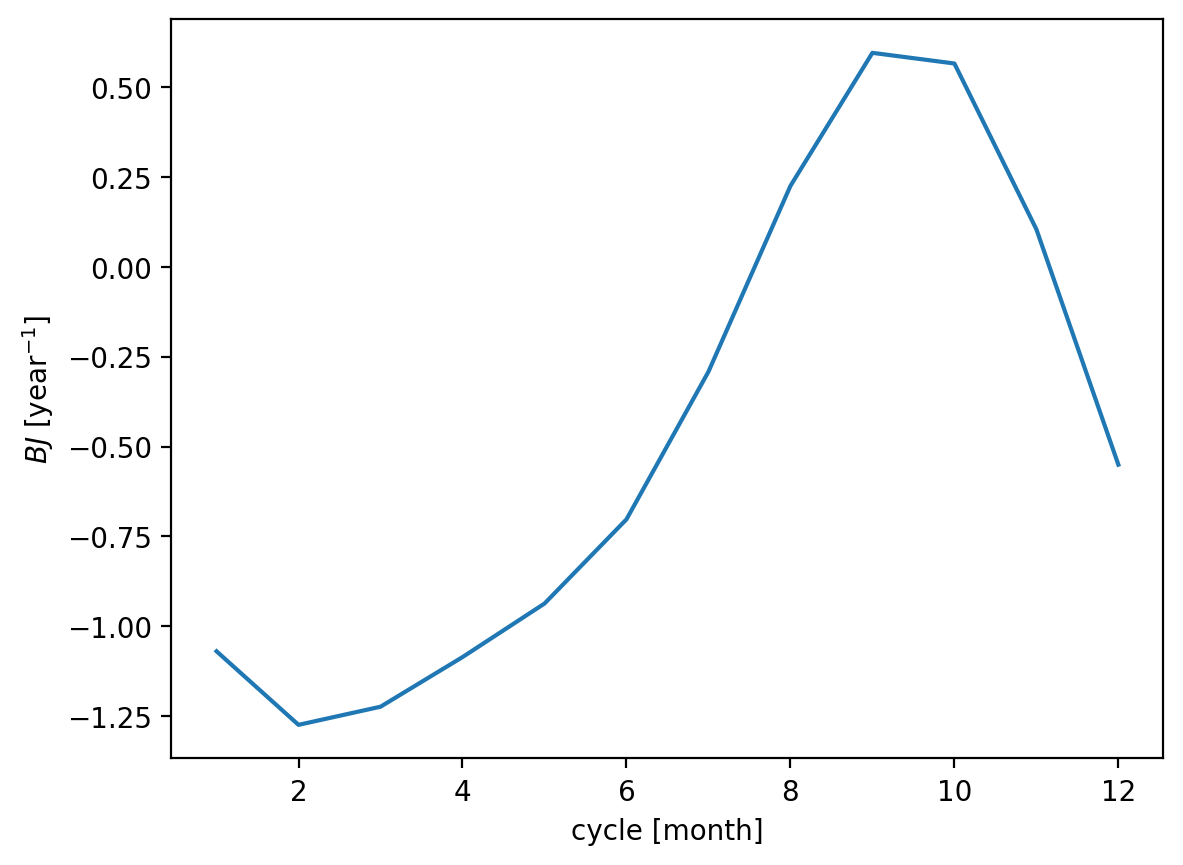

In [75]:
# model with annual mean, annual cycle, and semi-annual cycle
fit_NRO = fun_ac2.fit_matrix(train_ds, maskNT=['T2'], maskNH=['T2'])
fit_NRO_ds = fun_ac0.get_RO_parameters(fit_NRO)
fit_NRO_ds['BJ_ac'].plot()

seed = 1000
sim_NRO = fun_ac0.simulate(fit_ds=fit_NRO, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=500, noise_type='white', seed=seed, is_xi_stdac=False, xi_B=0.4, is_heaviside=True)  
print(sim_NRO)

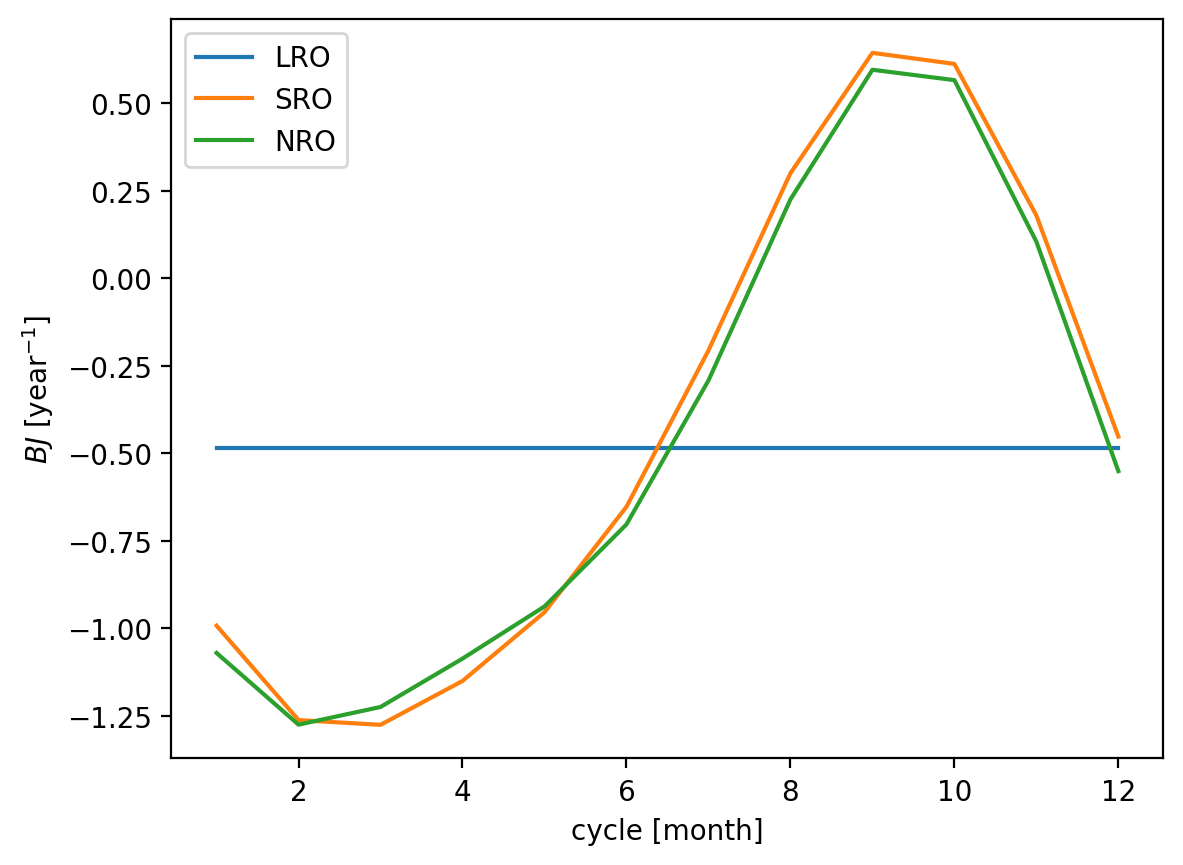

In [76]:
fit_LRO_ds['BJ_ac'].plot(label='LRO')
fit_SRO_ds['BJ_ac'].plot(label='SRO')
fit_NRO_ds['BJ_ac'].plot(label='NRO')
plt.legend()

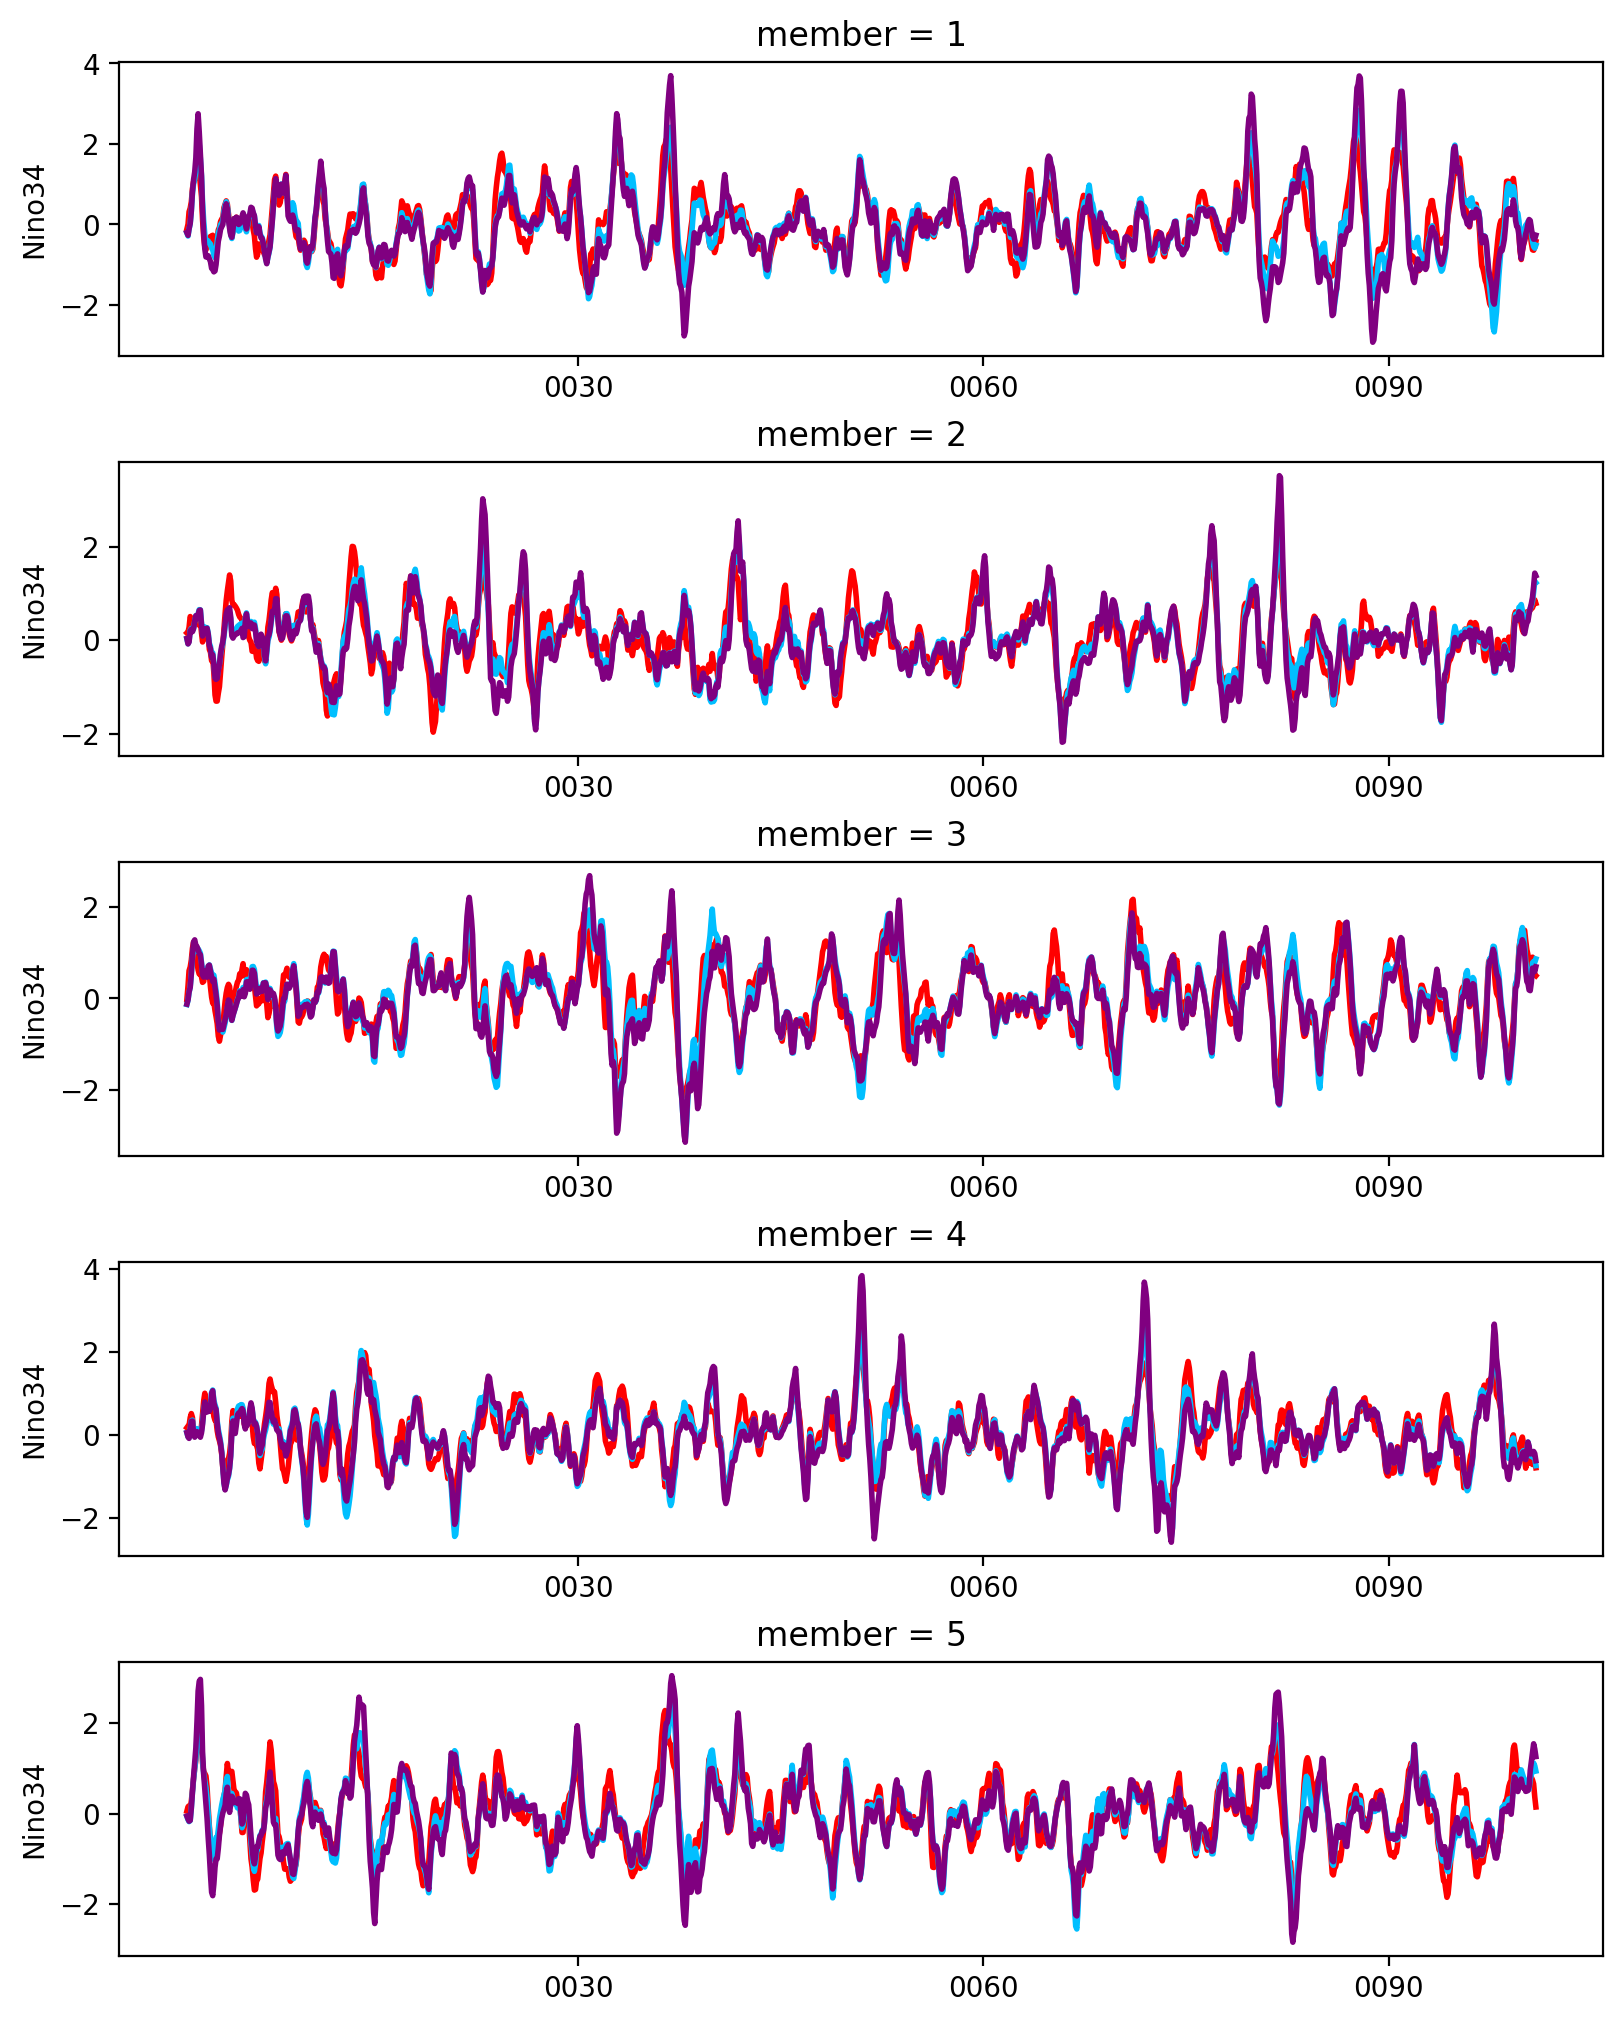

In [77]:
nmember=5
fig, axes = plt.subplots(nmember, 1, figsize=(8, nmember*2), layout='compressed')

for i, ax in enumerate(axes.flat):
    sim_LRO.isel(member=i+1)['Nino34'].plot(ax=ax, c='r', lw=2)
    sim_SRO.isel(member=i+1)['Nino34'].plot(ax=ax, c='deepskyblue', lw=2)
    sim_NRO.isel(member=i+1)['Nino34'].plot(ax=ax, c='purple', lw=2)
    ax.set_xlabel('')
    ax.set_xlim()


Text(0.5, 1.0, 'ENSO seasonal synchronization')

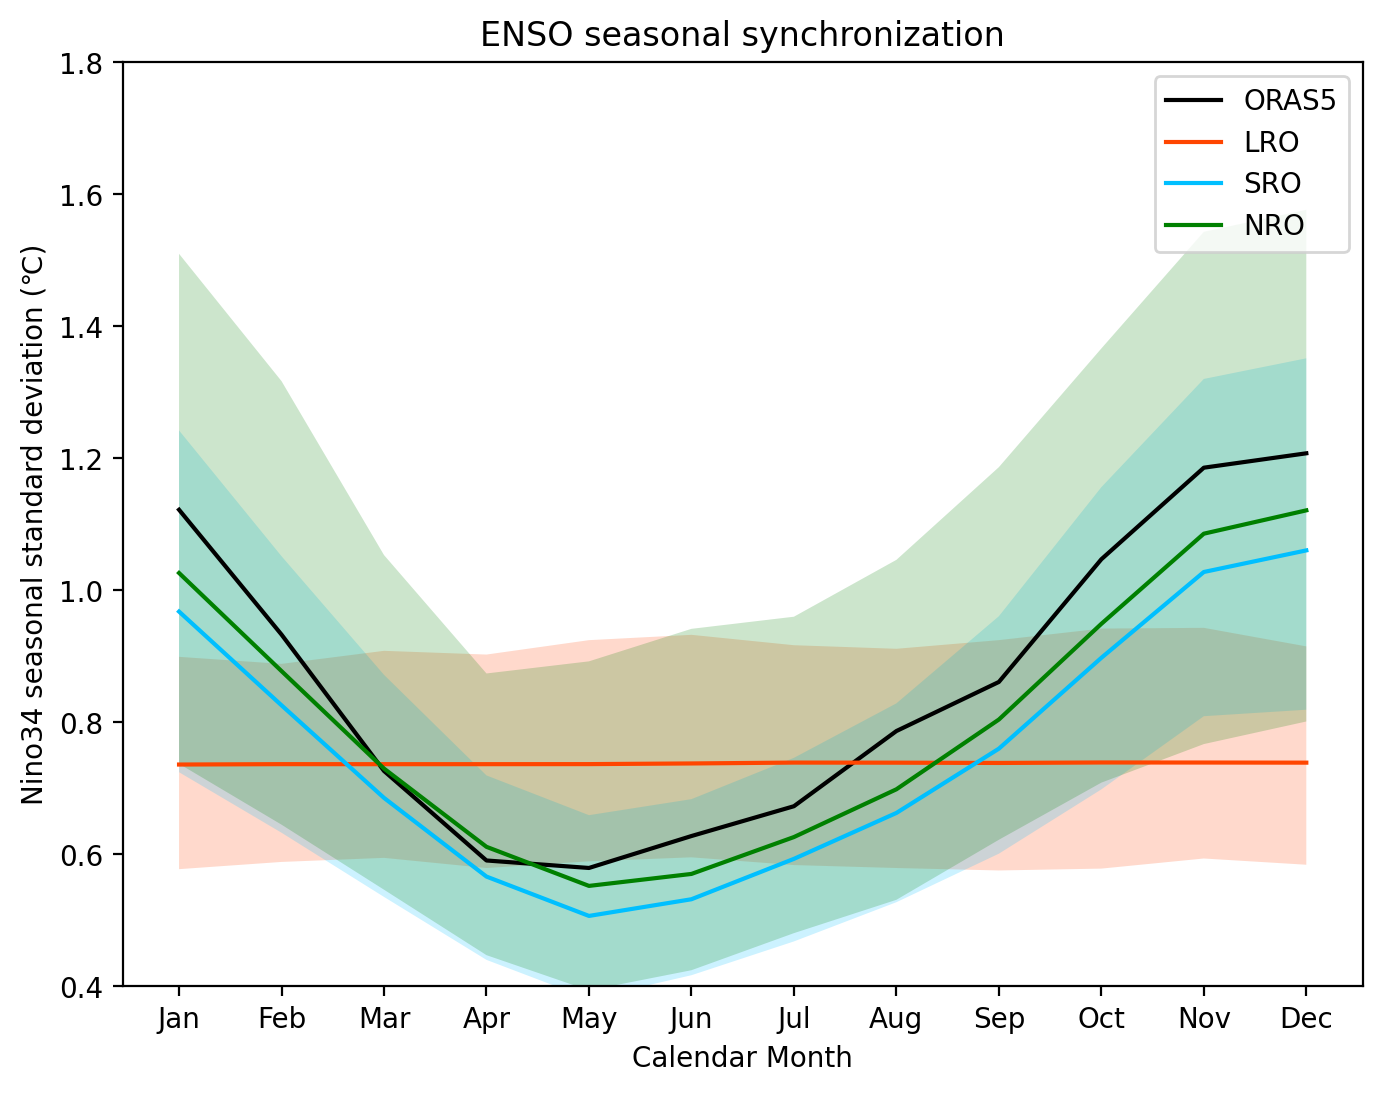

In [120]:
def plot_fill_between(x_ds, dim='member', c='orangered', alpha=0.2, xtime=None, ax=None, option=None, **kwargs):
    
    if xtime is None:
        from .climate import time_axis
        x_axis = time_axis(x_ds.time)
    else:
        x_axis = xtime

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    if option is None:
        x_lo = x_ds.mean(dim) - x_ds.std(dim)
        x_up = x_ds.mean(dim) + x_ds.std(dim)
    else:
        x_lo = x_ds.quantile(option, dim=dim)
        x_up = x_ds.quantile(1-option, dim=dim)
        
    ax.plot(x_axis, x_ds.mean(dim), c=c, **kwargs)
    ax.fill_between(x_axis, x_lo, x_up, fc=c, alpha=alpha)
    return ax

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, obs_enso_ds[sel_var].groupby('time.month').std('time'), c='black', label='ORAS5')
plot_fill_between(sim_LRO[sel_var].groupby('time.month').std('time'), dim='member', c='orangered', alpha=0.2, xtime=x_month, ax=ax, option=0, label='LRO')
plot_fill_between(sim_SRO[sel_var].groupby('time.month').std('time'), dim='member', c='deepskyblue', alpha=0.2, xtime=x_month, ax=ax, option=0, label='SRO')
plot_fill_between(sim_NRO[sel_var].groupby('time.month').std('time'), dim='member', c='green', alpha=0.2, xtime=x_month, ax=ax, option=0, label='NRO')

plt.xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.legend()
plt.ylim([0.4, 1.8])
plt.title('ENSO seasonal synchronization')

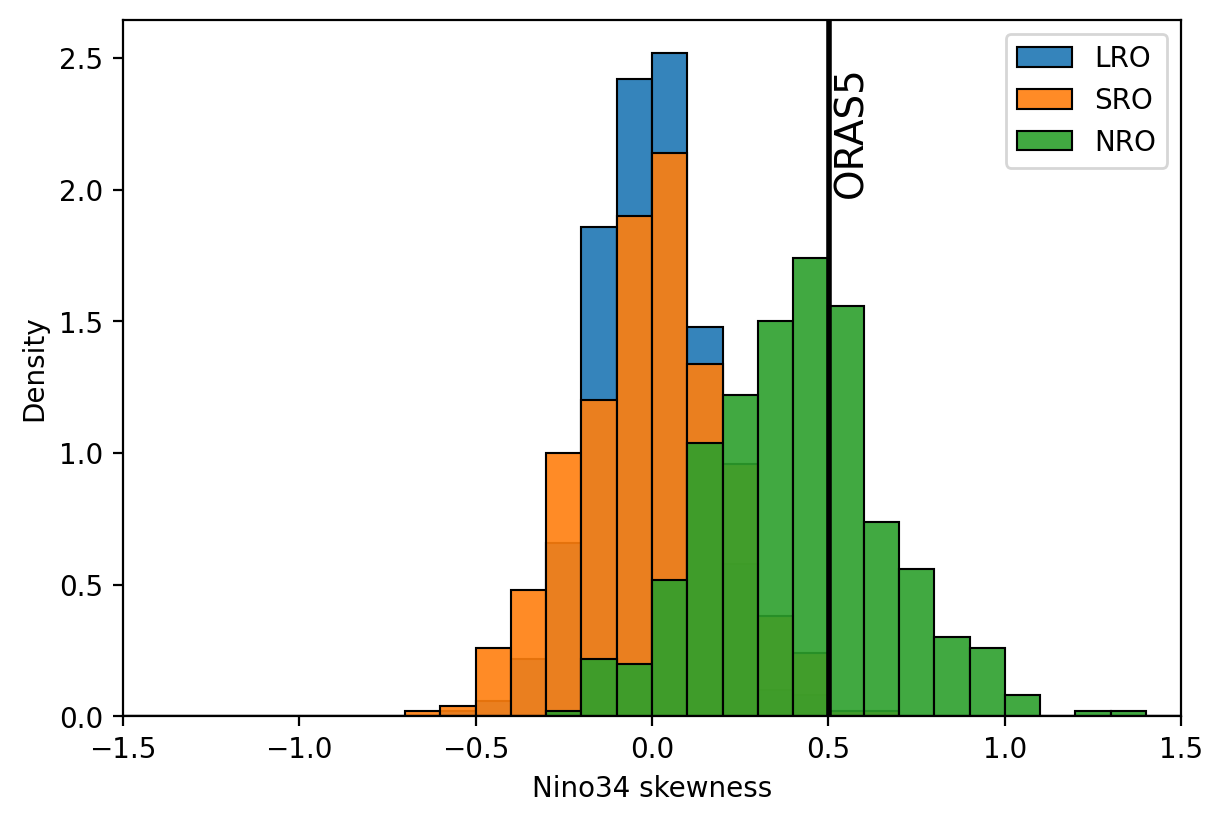

In [117]:
def compute_skew(da, dim):
    mean_da = da.mean(dim=dim)
    std_da = da.std(dim=dim)
    skewness = ((da - mean_da) / std_da) ** 3
    return skewness.mean(dim=dim)

@xr.register_dataarray_accessor("skew")
class SkewAccessor:
    '''
        calculate the skewness using xarray 
    '''
    def __init__(self, xarray_obj):
        self._obj = xarray_obj

    def __call__(self, dim='time'):
        """
        Compute the skewness along the given dimension.
        """
        if isinstance(self._obj, xr.DataArray):
            return compute_skew(self._obj, dim)

        elif isinstance(self._obj, xr.Dataset):
            skews = {}
            for name, da in self._obj.data_vars.items():
                skews[name] = compute_skew(da, dim)
            return xr.Dataset(skews)


sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True, layout='compressed')

bins = np.arange(-2, 2.01, step=0.1)
model_lists = [sim_LRO, sim_SRO, sim_NRO]
model_labels = ['LRO', 'SRO', 'NRO']

for i, model_ds  in enumerate(model_lists):
    sns.histplot(model_ds[sel_var].skew('time'), stat='density', bins=bins, ax=ax, alpha=0.9, label=model_labels[i])

ax.axvline(obs_enso_ds[sel_var].skew('time'), c='black', lw=2)
ax.set_xlim([-1.5, 1.5])
ax.set_xlabel(f'{sel_var} skewness')
ax.text( obs_enso_ds[sel_var].skew('time')+0.01, 2., 'ORAS5', rotation=90, fontsize=14)
ax.legend()

In [132]:
ccr_obs = xcorr(train_ds, train_ds['Nino34'], maxlags=36)
ccr_LRO = xcorr(sim_LRO, sim_LRO['Nino34'], maxlags=36)
ccr_SRO = xcorr(sim_SRO, sim_SRO['Nino34'], maxlags=36)
ccr_NRO = xcorr(sim_NRO, sim_NRO['Nino34'], maxlags=36)

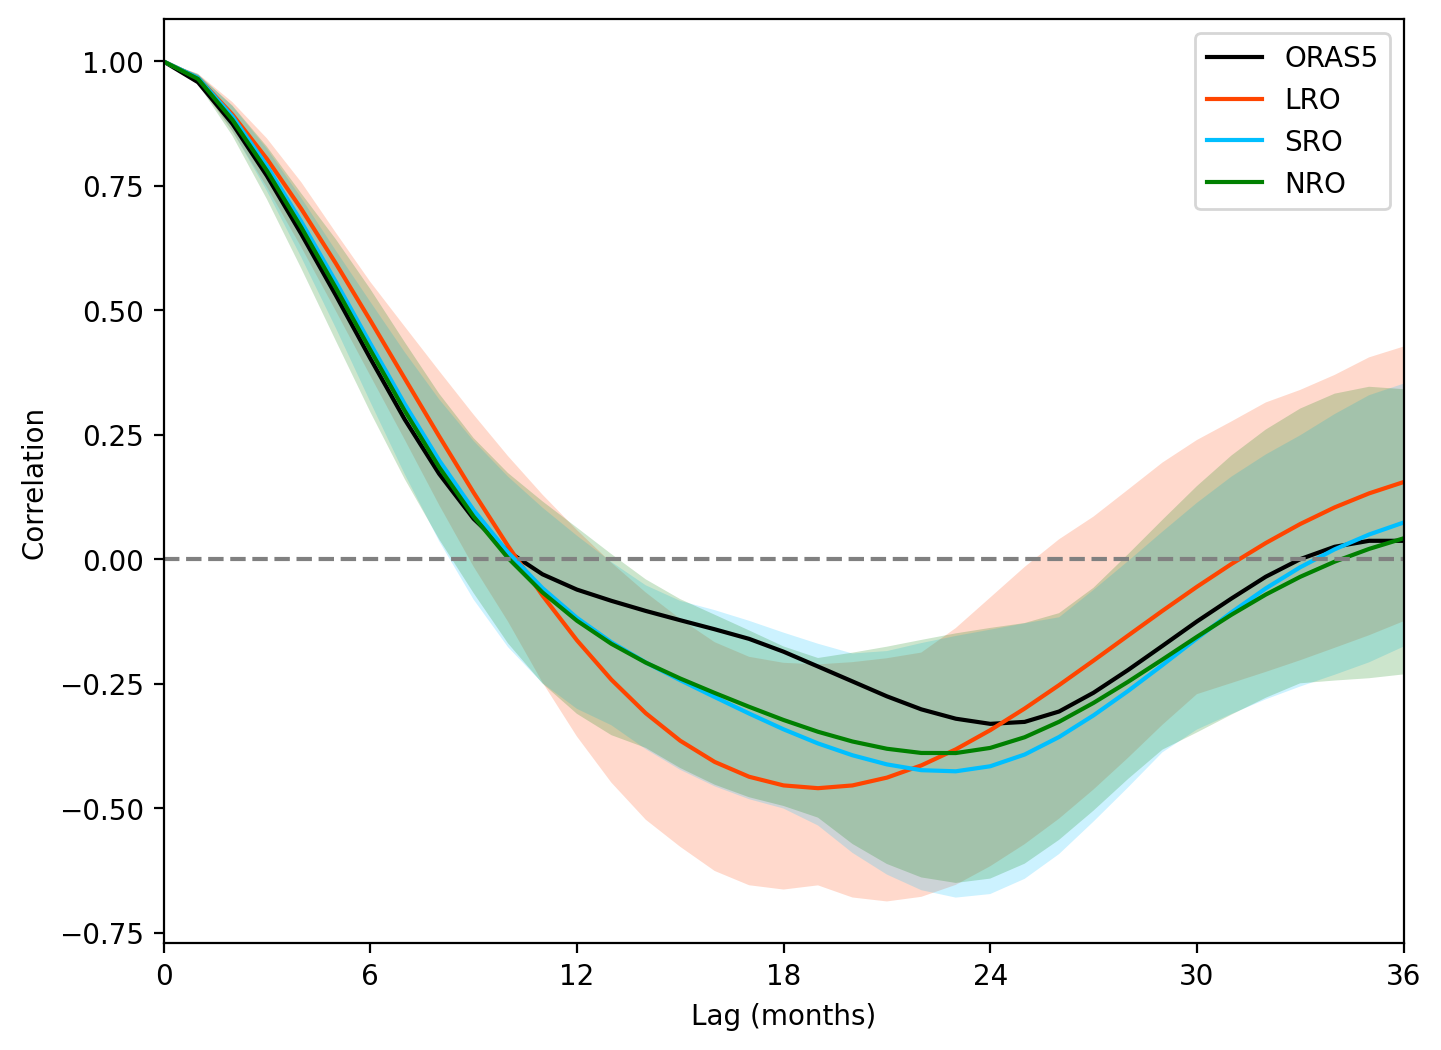

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(ccr_obs.lag, ccr_obs[sel_var], c='black', label='ORAS5')
plot_fill_between(ccr_LRO[sel_var], dim='member', c='orangered', alpha=0.2, xtime=ccr_LRO.lag, ax=ax, option=0, label='LRO')
plot_fill_between(ccr_SRO[sel_var], dim='member', c='deepskyblue', alpha=0.2, xtime=ccr_SRO.lag, ax=ax, option=0, label='SRO')
plot_fill_between(ccr_NRO[sel_var], dim='member', c='green', alpha=0.2, xtime=ccr_NRO.lag, ax=ax, option=0, label='NRO')

plt.ylabel('Correlation')
plt.xlabel('Lag (months)')
plt.xlim([0, 36])
plt.xticks(np.arange(0, 37, step=6))
plt.axhline(0, ls='--', c='gray')
plt.legend()
# plt.title('ENSO seasonal synchronization')


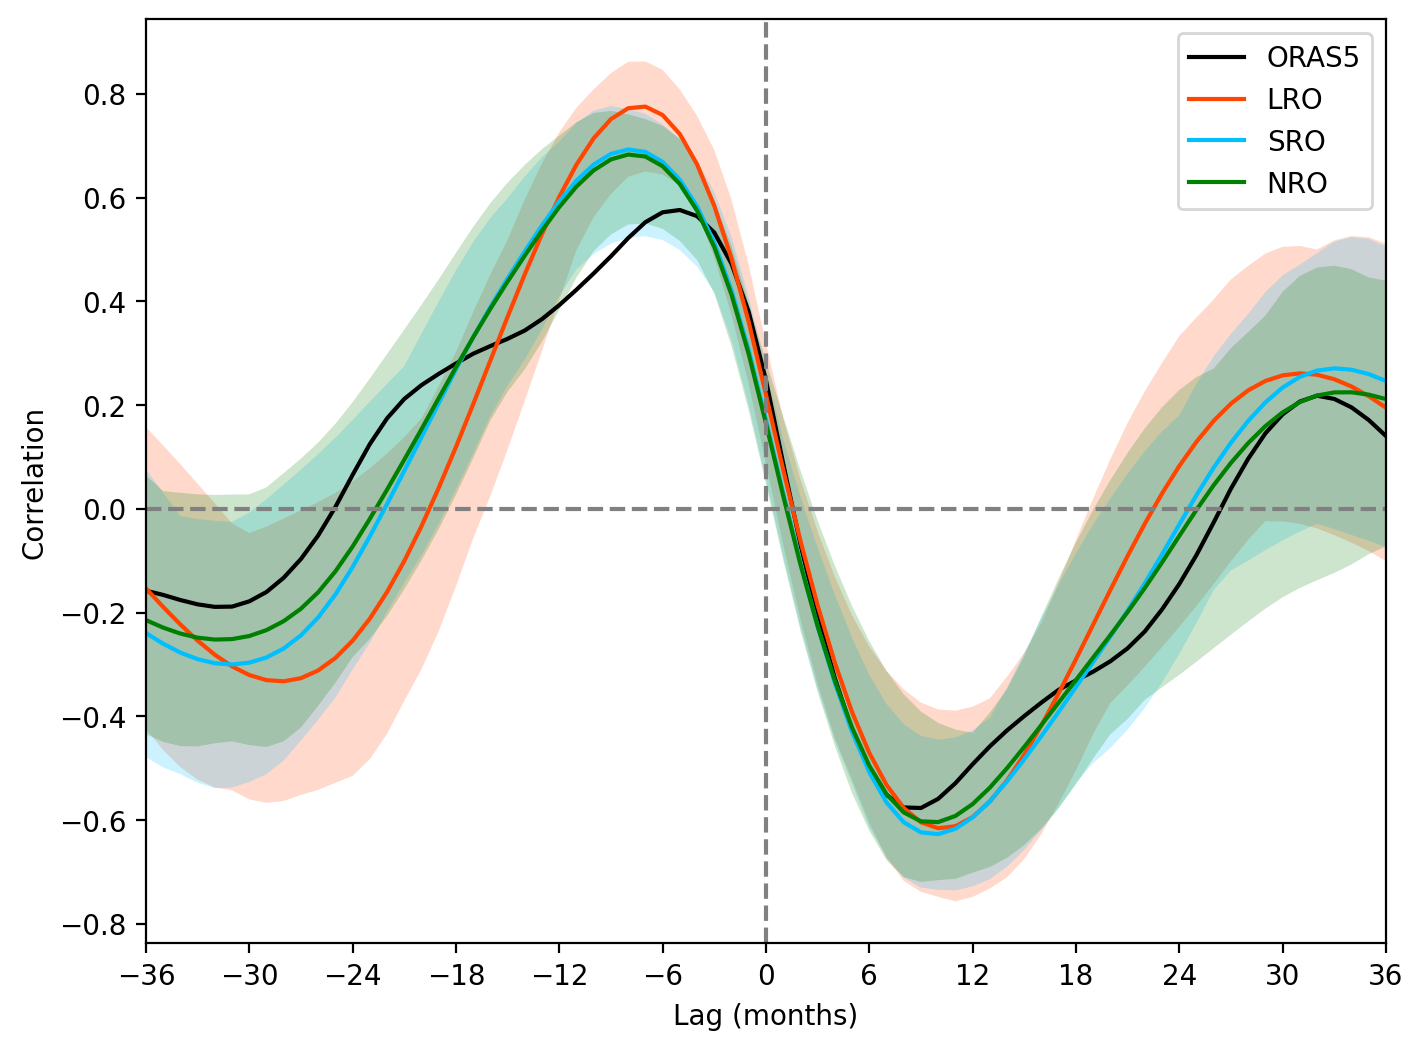

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sel_var = 'WWV'
ax.plot(ccr_obs.lag, ccr_obs[sel_var], c='black', label='ORAS5')
plot_fill_between(ccr_LRO[sel_var], dim='member', c='orangered', alpha=0.2, xtime=ccr_LRO.lag, ax=ax, option=0, label='LRO')
plot_fill_between(ccr_SRO[sel_var], dim='member', c='deepskyblue', alpha=0.2, xtime=ccr_SRO.lag, ax=ax, option=0, label='SRO')
plot_fill_between(ccr_NRO[sel_var], dim='member', c='green', alpha=0.2, xtime=ccr_NRO.lag, ax=ax, option=0, label='NRO')

plt.ylabel('Correlation')
plt.xlabel('Lag (months)')
plt.xlim([-36, 36])
plt.xticks(np.arange(-36, 37, step=6))
plt.axhline(0, ls='--', c='gray')
plt.axvline(0, ls='--', c='gray')
plt.legend()


In [145]:
######################################################################

def pmtm(ds_x, dim='time', dt=1/12., nw=4, cl=0.95, nfft=None, scale_by_freq=True):
    """
    Thomson’s multitaper power spectral density (PSD) estimate, 
    PSD significance level estimate, Confidence Intervals

    PSD estimate modified from Peter Huybers's matlab code, pmtmPH.m
    PSD significance level estimate modified from NCAR/NCL specx_ci 

    Parameters
    ----------
    x : numpy array
        Time series to analyze
    dt : float
        Sampling interval, default is 1.
    nw : float
        The time bandwidth product, available 
    cl : float
        Confidence interval to calculate and display
    nfft: int
        Default 

    Returns
    -------
    x_P : xarray DataArray
        PSD estimate via the multi-taper method.
    x_s : xarray DataArray
        Associated frequencies.
    x_P_sig : xarray DataArray
        PSD significance level estimate.
    x_ci : xarray DataArray
        Confidence intervals.
    """
    P_ds, s_ds, Psig_ds, ci_ds = xr.apply_ufunc(_pmtm, ds_x, input_core_dims=[[dim]],
                             output_core_dims=[['freq'], ['freq'], ['freq'], ['freq', 'bound', ]],
                             kwargs={'dt': dt, 'nw': nw, 'cl': cl,
                                     'nfft': nfft, 'scale_by_freq': scale_by_freq},
                             vectorize=True)
    if len(s_ds.dims)==1:
        P_ds = P_ds.assign_coords({'freq': s_ds})
        Psig_ds = Psig_ds.assign_coords({'freq': s_ds})
        ci_ds = ci_ds.assign_coords({'freq': s_ds})
    else:
        mem_dim = list(s_ds.dims)[0]
        P_ds = P_ds.assign_coords({'freq': s_ds.isel({mem_dim: 0}).values})
        Psig_ds = Psig_ds.assign_coords({'freq': s_ds.isel({mem_dim: 0}).values})
        ci_ds = ci_ds.assign_coords({'freq': s_ds.isel({mem_dim: 0}).values})
    return P_ds, Psig_ds, ci_ds


def _pmtm(x, dt=1, nw=4, cl=0.95, nfft=None, scale_by_freq=True):
    '''
        numpy of pmtm
    '''

    from scipy.signal import windows
    from scipy.stats import chi2

    if nfft is None:
        nfft = np.shape(x)[0]

    nx = np.shape(x)[0]
    k = min(np.round(2.*nw), nx)
    k = int(max(k-1, 1))
    s = np.arange(0, 1/dt, 1/(nfft*dt))

    # Compute the discrete prolate spheroidal sequences
    [E, V] = windows.dpss(nx, nw, k, return_ratios=True)
    E = E.T

    # Compute the windowed DFTs.
    Pk = np.abs(np.fft.fft(E*x[:, np.newaxis], nfft, axis=0))**2

    # Iteration to determine adaptive weights
    if k > 1:
        sig2 = np.dot(x[np.newaxis, :], x[:, np.newaxis])[0][0]/nx # power
        # initial spectrum estimate
        P = ((Pk[:, 0] + Pk[:, 1])/2)[:, np.newaxis]
        Ptemp = np.zeros((nfft, 1))
        P1 = np.zeros((nfft, 1))
        tol = .0005*sig2/nfft
        a = sig2*(1-V)

        while (np.sum(np.abs(P - P1)/nfft) > tol):
            b = np.repeat(P, k, axis=-1)/(P*V[np.newaxis, :] + np.ones((nfft, 1))*a[np.newaxis, :])
            wk = (b**2) * (np.ones((nfft, 1))*V[np.newaxis, :])
            P1 = (np.sum(wk*Pk, axis=-1)/np.sum(wk, axis=-1))[:, np.newaxis]

            Ptemp = np.empty_like(P1)
            Ptemp[:] = P1
            P1 = np.empty_like(P)
            P1[:] = P
            P = np.empty_like(Ptemp)
            P[:] = Ptemp

        # Determine equivalent degrees of freedom, see Percival and Walden 1993.
        v = ((2*np.sum((b**2)*(np.ones((nfft, 1))*V[np.newaxis, :]), axis=-1)**2) /
             np.sum((b**4)*(np.ones((nfft, 1))*V[np.newaxis, :]**2), axis=-1))

    else:
        P = np.empty_like(Pk)
        P[:] = Pk
        v = 2*np.ones((nfft, 1))

    select = (np.arange(0, (nfft + 1)/2.)).astype('int')
    P = P[select].flatten()
    s = s[select].flatten()
    v = v[select].flatten()

    # Whether the resulting density values should be scaled by the scaling frequency, which gives density in units of 1/day, 1/year, or 1/Hz.
    # This allows for integration over the returned frequency values
    if scale_by_freq:
        P *= dt

    # Chi-squared 95% confidence interval
    # approximation from Chamber's et al 1983; see Percival and Walden p.256, 1993
    ci = np.empty((np.shape(v)[0], 2))
    ci[:, 0] = 1./(1-2/(9*v) - 1.96*np.sqrt(2/(9*v)))**3
    ci[:, 1] = 1./(1-2/(9*v) + 1.96*np.sqrt(2/(9*v)))**3

    # red noise significance levels
    # PSD significance level estimate modified from NCAR/NCL specx_ci 
    alpha = np.corrcoef(x[:-1], x[1:])[0, 1]
    dof = v
    P_red = (1 - alpha**2) / (1 + alpha**2 - 2 * alpha * np.cos(2 * np.pi * s * dt))
    # rescale
    scale = np.sum(P)/np.sum(P_red)
    quantile = chi2.ppf(cl, dof)
    P_sig = P_red * scale * quantile / dof

    x_s = xr.DataArray(s, dims=['freq'], coords={'freq': s})
    x_P = xr.DataArray(P, dims=['freq'], coords={'freq': s})
    x_P_sig = xr.DataArray(P_sig, dims=['freq'], coords={'freq': s})
    x_ci = xr.DataArray(ci, dims=['freq', 'bound'], coords={'freq': s, 'bound': [0, 1]})
    return x_P, x_s, x_P_sig, x_ci



psd_obs, sigpsd_obs, _ = pmtm( train_ds[sel_var], dim='time', dt=1/12, nw=5)
psd_LRO, sigpsd_LRO, _ = pmtm( sim_LRO[sel_var], dim='time', dt=1/12, nw=5)
psd_SRO, sigpsd_SRO, _ = pmtm( sim_SRO[sel_var], dim='time', dt=1/12, nw=5)
psd_NRO, sigpsd_NRO, _ = pmtm( sim_SRO[sel_var], dim='time', dt=1/12, nw=5)


Text(0.5, 1.0, 'Spectrum of Niño3 SST anomaly')

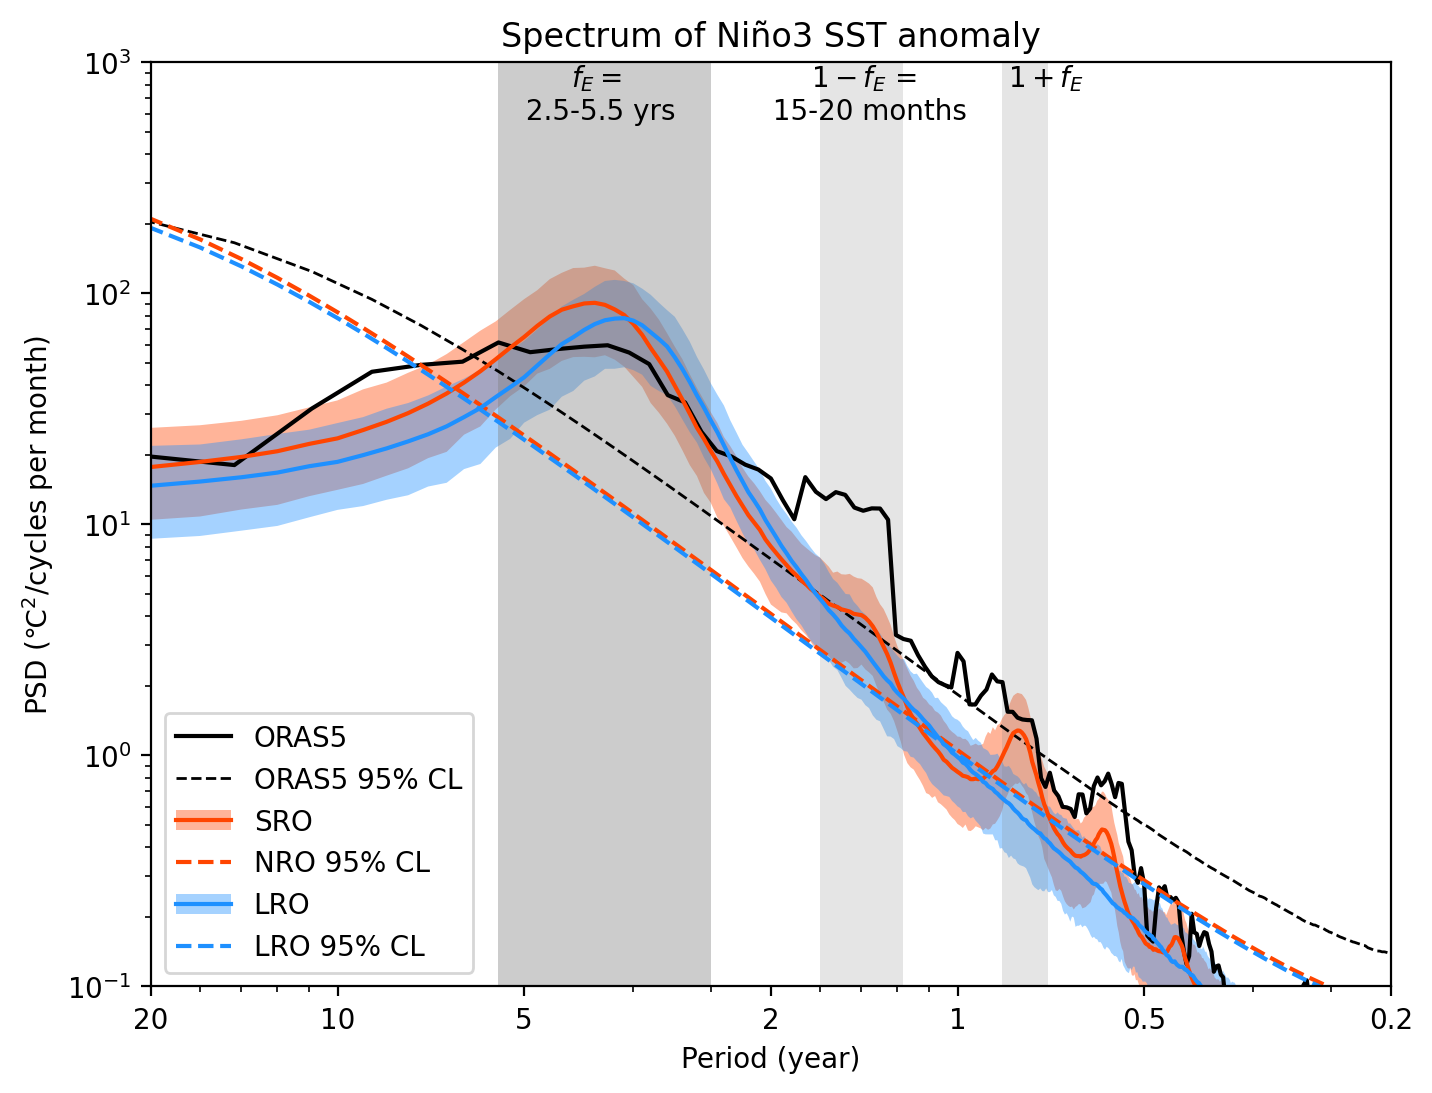

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(sigpsd_obs.freq, sigpsd_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

ax.loglog(psd_SRO.freq, psd_SRO.mean('member'), lw=1.5, color='orangered', label='SRO')
ax.fill_between(psd_SRO.freq, psd_SRO.quantile(0.1, dim='member'), psd_SRO.quantile(0.9, dim='member'), fc='orangered', label='SRO', alpha=0.4)
ax.semilogx(sigpsd_SRO.freq, sigpsd_SRO.mean('member'), color='orangered', linestyle='--', label='NRO 95% CL')

ax.loglog(psd_LRO.freq, psd_LRO.mean('member'), lw=1.5, color='dodgerblue', label='LRO')
ax.fill_between(psd_LRO.freq, psd_LRO.quantile(0.1, dim='member'), psd_LRO.quantile(0.9, dim='member'), fc='dodgerblue', label='LRO', alpha=0.4)
ax.semilogx(sigpsd_LRO.freq, sigpsd_LRO.mean('member'), color='dodgerblue', linestyle='--', label='LRO 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-1, 1000])

sp.legend_combo(ax, loc='lower left')
# ax.legend(loc='right')

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3 SST anomaly')


## XRO training

The XRO model form : dX/dt = L * X + NRO_T + NRO_H + \xi

NRO_T is nonlinear terms in ENSO's T equation
NRO_H is nonlinear terms is ENSO's H equation

**XRO equation forms**

- The standard XRO model in Zhao et al. (2024) is maskb for ENSO's SST and IOD's SST and T*H term in ENSO SST equation, thus `maskb=['IOD']`, `maskNT=['T2', 'TH']`
- The linear form of XRO is setting `maskb=[]` and `maskNT=[]`

In [1]:
# XRO model used as control experiment in the paper
ROac2_fit = ROac2.fit_matrix(train_ds, maskNT=['T2'], maskNH=['T2'])
print('XRO control model parameters')
print(ROac2_fit)

# XRO ac=0 model
ROac0_fit = ROac0.fit_matrix(train_ds, maskNT=['T2'], maskNH=['T2'])
print('XRO(ac=0) model parameters')
print(ROac0_fit)

NameError: name 'ROac2' is not defined

In [ ]:
fitROac0_ds = ROac0.get_RO_parameters(ROac0_fit)
fitROac2_ds = ROac0.get_RO_parameters(ROac2_fit)
fitROac2_ds

In [ ]:
ROac2_fit_m = ROac0.set_NRO_annualmean(ROac2_fit)
ROac2_fit_m

In [ ]:
# fitROac0_ds['R'].plot()
# fitROac2_ds['R'].plot()

fitROac0_ds['F1'].plot()
fitROac2_ds['bT_1'].plot()

fitROac0_ds['bH_2'].plot()
fitROac2_ds['bH_2'].plot()


## XRO stochastic simulation

stochastic simulation (as an example, initial from observed 1979-01, each model run 100 years with 100 realiazations)

- set `seed` to int number to get the exact same result (default is None)
- set `is_xi_stdac=True` if consider seasonal modulation of noise amplitde (default is None)

The output is archived as monthly mean of state vectors


In [ ]:
seed = 1000

ROac2_sim = ROac2.simulate(fit_ds=ROac2_fit, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=100, noise_type='white', seed=seed, is_xi_stdac=False, xi_B=0.4)  
print('XRO control stochastic simulation')
print(ROac2_sim)

ROac0_sim = ROac2.simulate(fit_ds=ROac2_fit, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=100, noise_type='white', seed=seed, is_xi_stdac=False, xi_B=0.4, is_heaviside=True)  #set seed=1000 to get the exact same result

# ROac0_sim = ROac0.simulate(fit_ds=ROac0_fit, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=100, noise_type='white', is_xi_stdac=False)  
print('XRO control stochastic simulation')
print(ROac0_sim)

# print('XRO(ac=0) model stochastic simulation')
# print(ROac0_sim)

### Simulating Metric Exmaple 1: ENSO irregular interannual oscillations in XRO
Show the time series of each member

In [ ]:
nmember=5
fig, axes = plt.subplots(nmember, 1, figsize=(8, nmember*2), layout='compressed')

for i, ax in enumerate(axes.flat):
    ROac2_sim.isel(member=i+1)['Nino34'].plot(ax=ax, c='r', lw=2)
    ROac0_sim.isel(member=i+1)['Nino34'].plot(ax=ax, c='deepskyblue', lw=2)
    ax.set_xlabel('')

### Simulating Metric Exmaple 2: ENSO seasonal synchronization example

In the following code block, we calcualte the Nino34 seasonal standard deviation (stddev) for observation (ORAS5), XRO control simulation, and XRO(ac=0) simulation.

- As shown in the figure, XRO accurately simulates observed ENSO seasonal synchronization (comoare black curve and red curve)
- If we don't include the seasonal cycle in the XRO operators, there is no seasonal synchronization (blue curve)


In [ ]:
def plot_fill_between(

stddev_obs = train_ds.groupby('time.month').std('time')

stddev_ROac2 = ROac2_sim.groupby('time.month').std('time')
stddev_ROac2_m = stddev_ROac2.mean('member')
stddev_ROac2_e = stddev_ROac2.std('member')

stddev_ROac0 = ROac0_sim.groupby('time.month').std('time')
stddev_ROac0_m = stddev_ROac0.mean('member')
stddev_ROac0_e = stddev_ROac0.std('member')

sel_var = 'Nino34'
plt.plot(stddev_obs.month, stddev_obs[sel_var], c='black', label='ORAS5')
plt.plot(stddev_ROac2_m.month, stddev_ROac2_m[sel_var], c='orangered', label='RO')
plt.fill_between(stddev_ROac2_m.month, (stddev_ROac2_m-stddev_ROac2_e)[sel_var], (stddev_ROac2_m+stddev_ROac2_e)[sel_var], fc='orangered', alpha=0.5)
plt.plot(stddev_ROac0_m.month, stddev_ROac0_m[sel_var], c='deepskyblue', label='RO$_{ac=0}$')
plt.fill_between(stddev_ROac0_m.month, (stddev_ROac0_m-stddev_ROac0_e)[sel_var], (stddev_ROac0_m+stddev_ROac0_e)[sel_var], fc='deepskyblue', alpha=0.5)
plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.title('XRO accurately simulates ENSO seasonal synchronization')


In [ ]:
# # as exmaple shown the 
# stddev_obs = train_ds.groupby('time.month').skew('time')

# stddev_ROac2 = ROac2_sim.groupby('time.month').skew('time')
# stddev_ROac2_m = stddev_ROac2.mean('member')
# stddev_ROac2_e = stddev_ROac2.std('member')

# stddev_ROac0 = ROac0_sim.groupby('time.month').skew('time')
# stddev_ROac0_m = stddev_ROac0.mean('member')
# stddev_ROac0_e = stddev_ROac0.std('member')

# sel_var = 'Nino34'
# plt.plot(stddev_obs.month, stddev_obs[sel_var], c='black', label='ORAS5')
# plt.plot(stddev_ROac2_m.month, stddev_ROac2_m[sel_var], c='orangered', label='RO')
# plt.fill_between(stddev_ROac2_m.month, (stddev_ROac2_m-stddev_ROac2_e)[sel_var], (stddev_ROac2_m+stddev_ROac2_e)[sel_var], fc='orangered', alpha=0.5)
# plt.plot(stddev_ROac0_m.month, stddev_ROac0_m[sel_var], c='deepskyblue', label='RO$_{ac=0}$')
# plt.fill_between(stddev_ROac0_m.month, (stddev_ROac0_m-stddev_ROac0_e)[sel_var], (stddev_ROac0_m+stddev_ROac0_e)[sel_var], fc='deepskyblue', alpha=0.5)
# plt.legend()
# plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# plt.ylabel('Nino34 seasonal standard deviation (℃)')
# plt.xlabel('Calendar Month')
# plt.title('XRO accurately simulates ENSO seasonal synchronization')


## XRO reforecasting

reforecasting (as an example, initial from observed 1979-01 to 2023-10, each run 21 months)
- `fit_ds` is the trained operators, in which linear/nonlinear operators `Lac`/`NLac` as well as noise parameters `xi_std` and `xi_a1` will be used
- `init_ds` is initial condictions, the order of variables has been the same with the trained parameters
- determinsitc forecast by setting `noise_type='zero'` 
- stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)


In [ ]:
ROac0_fcst = ROac0.reforecast(fit_ds=ROac2_fit, init_ds=obs_enso_ds, n_month=21, ncopy=1, noise_type='zero')
ROac0_fcst

ROac2_fcst = ROac2.reforecast(fit_ds=ROac2_fit, init_ds=obs_enso_ds, n_month=21, ncopy=1, noise_type='zero', xi_B=0.4)
print(ROac2_fcst)

### forecast skill performance using `climpred`


In [ ]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1979-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

### correlation skill
In-sample correlation skill of XRO and XRO(ac=0) for 1979-2022

In [ ]:
acc_ROac0 = calc_forecast_skill(ROac0_fcst, obs_enso_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
acc_ROac0

acc_ROac2 = calc_forecast_skill(ROac2_fcst, obs_enso_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
print(acc_ROac2)

In [ ]:
# acc_ROac2 = calc_forecast_skill(ROac2_fcst, obs_enso_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))

# print(acc_ROac2)


In [ ]:
sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
acc_ROac2[sel_var].plot(ax=ax, label='RO', c='orangered', lw=2)
acc_ROac0[sel_var].plot(ax=ax, label='RO$_{ac=0}$', c='deepskyblue', lw=2)

ax.set_ylabel('{0} skill'.format('Correlation') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 21])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast correlation skill (1979-2022)')
ax.legend()

### RMSE skill

In-sample RMSE skill of XRO and XRO(ac=0) for 1979-2022

In [ ]:
rmse_ROac0 = calc_forecast_skill(ROac0_fcst, obs_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
rmse_ROac0

rmse_ROac2 = calc_forecast_skill(ROac2_fcst, obs_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
rmse_ROac2

sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
rmse_ROac2[sel_var].plot(ax=ax, label='RO', c='orangered', lw=2)
rmse_ROac0[sel_var].plot(ax=ax, label='RO$_{ac=0}$', c='deepskyblue', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 21])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast RMSE skill (1979-2022)')
ax.legend()

## XRO stochastic reforecasting
 - stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)

It will take a while since you have 100 members, of course you can reduce the member size 

In [ ]:
ROac2_fcst_stoc = ROac2.reforecast(fit_ds=ROac2_fit, init_ds=obs_enso_ds, n_month=21, ncopy=100, seed=1000, noise_type='white', xi_B=1)
print(ROac2_fcst_stoc)

In [ ]:
date_arrs = ['2014-04', '2015-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_d = ROac2_fcst['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_m = ROac2_fcst_stoc['Nino34'].sel(init=sel_date).mean('member').squeeze()
    sel_fcst_e = ROac2_fcst_stoc['Nino34'].sel(init=sel_date).std('member').squeeze()
    nlead = len(sel_fcst_m.lead)
    
    xdate_mid = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date()
    xdate_strt = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date() + relativedelta(months=-2)
    xdate_last = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date() + relativedelta(months=nlead-1)
    
    sel_obs = obs_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime = sel_obs.time
    xtime_fcst = xtime[2:]
    
    ax.plot(xtime_fcst, sel_fcst_m, c='orangered', marker='.', lw=3, label='100-members RO stochastic forecasts')

    ax.fill_between(xtime_fcst,sel_fcst_m-sel_fcst_e, sel_fcst_m + sel_fcst_e, fc='red', alpha=0.3, ) #label='100-members stochastic forecasts'
    ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='deterministic RO forecast' )
    ax.plot(xtime, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5 )

    ax.axhline(y=0., c = 'black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator( interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))
    # ax.set_xticklabels(xdate_minorticks , minor=True,) 

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])
    
    ax.set_title("Initialized from {0}".format(sel_date))
    # ax.set_xlim([1980, 2025])
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')
    ax.axhline(0, c='k', ls='--', alpha=0.3)
    ax.legend()

fig.tight_layout()